# Modeling

In [22]:
import h2o,os
from h2o.estimators import H2OGradientBoostingEstimator
from h2o.grid.grid_search import H2OGridSearch
from sklearn.metrics import auc, roc_curve
import matplotlib.pyplot as plt
import seaborn as sns 

In [2]:
h2o.init()

Checking whether there is an H2O instance running at http://localhost:54321 ..... not found.
Attempting to start a local H2O server...
  Java Version: java version "12.0.1" 2019-04-16; Java(TM) SE Runtime Environment (build 12.0.1+12); Java HotSpot(TM) 64-Bit Server VM (build 12.0.1+12, mixed mode, sharing)
  Starting server from /Users/Qiqi/opt/anaconda3/lib/python3.7/site-packages/h2o/backend/bin/h2o.jar
  Ice root: /var/folders/6s/drrt_2sn0hqd8llkvsyh_pjc0000gn/T/tmp7w30u921
  JVM stdout: /var/folders/6s/drrt_2sn0hqd8llkvsyh_pjc0000gn/T/tmp7w30u921/h2o_Qiqi_started_from_python.out
  JVM stderr: /var/folders/6s/drrt_2sn0hqd8llkvsyh_pjc0000gn/T/tmp7w30u921/h2o_Qiqi_started_from_python.err
  Server is running at http://127.0.0.1:54323
Connecting to H2O server at http://127.0.0.1:54323 ... successful.


H2O cluster uptime:,02 secs
H2O cluster timezone:,America/New_York
H2O data parsing timezone:,UTC
H2O cluster version:,3.28.0.2
H2O cluster version age:,1 day
H2O cluster name:,H2O_from_python_Qiqi_ri7pp6
H2O cluster total nodes:,1
H2O cluster free memory:,2 Gb
H2O cluster total cores:,4
H2O cluster allowed cores:,4
H2O cluster status:,"accepting new members, healthy"


In [3]:
df = h2o.import_file(os.path.realpath("../lib/train_data.csv"))

Parse progress: |█████████████████████████████████████████████████████████| 100%


In [4]:
cat_features = [] 
for k,v in df.types.items():
    if v == 'enum':
        cat_features.append(k)

In [5]:
# For binary classification, response should be a factor
df['default'] = df['default'].asfactor()

# make categorical feature to factor
for name in cat_features:
    df[name] = df[name].asfactor()

In [6]:
response  = "default"
predictors = list(set(df.columns) - set(["default"]))

In [7]:
# Randomly split the data into 70% training and 30% testing.
train, test = df.split_frame(ratios=[0.7], seed=121)

In [8]:
# gradient boosting cross validation 
gbm_model=H2OGradientBoostingEstimator(balance_classes = True, score_tree_interval=10,
                                          ntrees=100,
                                          sample_rate=0.8,
                                          col_sample_rate=0.8,
                                          stopping_rounds=5,
                                          stopping_metric="AUC",
                                          stopping_tolerance=0.001,
                                     nfolds = 5,  keep_cross_validation_fold_assignment = True,seed=121)

gbm_model.train(x=predictors, y=response, training_frame=train)

gbm Model Build progress: |███████████████████████████████████████████████| 100%


In [9]:
gbm_model

Model Details
H2OGradientBoostingEstimator :  Gradient Boosting Machine
Model Key:  GBM_model_python_1579717812565_1


Model Summary: 


,,number_of_trees,number_of_internal_trees,model_size_in_bytes,min_depth,max_depth,mean_depth,min_leaves,max_leaves,mean_leaves
0,,100.0,100.0,45226.0,5.0,5.0,5.0,24.0,32.0,31.31




ModelMetricsBinomial: gbm
** Reported on train data. **

MSE: 0.2651590774098943
RMSE: 0.5149359935078284
LogLoss: 0.737945873019944
Mean Per-Class Error: 0.3217926450613624
AUC: 0.7450854356351045
AUCPR: 0.7288968305506013
Gini: 0.4901708712702091

Confusion Matrix (Act/Pred) for max f1 @ threshold = 0.16472625768915236: 


,,0,1,Error,Rate
0,0,80661.0,97764.0,0.5479,(97764.0/178425.0)
1,1,24459.0,154089.0,0.137,(24459.0/178548.0)
2,Total,105120.0,251853.0,0.3424,(122223.0/356973.0)



Maximum Metrics: Maximum metrics at their respective thresholds


,metric,threshold,value,idx
0,max f1,0.164726,0.716025,302.0
1,max f2,0.072361,0.841744,366.0
2,max f0point5,0.259692,0.679266,234.0
3,max accuracy,0.232863,0.678219,253.0
4,max precision,0.806385,1.000000,0.0
5,max recall,0.017141,1.000000,399.0
6,max specificity,0.806385,1.000000,0.0
7,max absolute_mcc,0.226355,0.357802,257.0
8,max min_per_class_accuracy,0.247478,0.675908,243.0
9,max mean_per_class_accuracy,0.232863,0.678207,253.0



Gains/Lift Table: Avg response rate: 50.02 %, avg score: 26.54 %


,,group,cumulative_data_fraction,lower_threshold,lift,cumulative_lift,response_rate,score,cumulative_response_rate,cumulative_score,capture_rate,cumulative_capture_rate,gain,cumulative_gain
0,,1,0.010006,0.639526,1.825239,1.825239,0.912934,0.679289,0.912934,0.679289,0.018264,0.018264,82.523895,82.523895
1,,2,0.020010,0.603231,1.756886,1.791067,0.878745,0.619588,0.895842,0.649443,0.017575,0.035839,75.688554,79.106703
2,,3,0.030002,0.576260,1.693837,1.758684,0.847211,0.589651,0.879645,0.629529,0.016925,0.052765,69.383745,75.868440
3,,4,0.040006,0.556251,1.693620,1.742415,0.847102,0.565451,0.871508,0.613506,0.016942,0.069707,69.361974,74.241482
4,,5,0.050004,0.538833,1.676643,1.729264,0.838610,0.547161,0.864930,0.600241,0.016763,0.086470,67.664280,72.926410
5,,6,0.100005,0.476622,1.597522,1.663395,0.799036,0.505936,0.831984,0.553089,0.079878,0.166347,59.752227,66.339503
6,,7,0.150000,0.433664,1.523877,1.616893,0.762201,0.454360,0.808725,0.520183,0.076187,0.242534,52.387679,61.689329
7,,8,0.200004,0.397616,1.442192,1.573216,0.721345,0.415107,0.786879,0.493912,0.072115,0.314649,44.219215,57.321556
8,,9,0.300003,0.338882,1.333434,1.493290,0.666947,0.366977,0.746902,0.451601,0.133342,0.447992,33.343415,49.328992
9,,10,0.399999,0.290238,1.208347,1.422057,0.604381,0.314058,0.711273,0.417217,0.120830,0.568822,20.834653,42.205657




ModelMetricsBinomial: gbm
** Reported on cross-validation data. **

MSE: 0.15855050832713913
RMSE: 0.3981840131486184
LogLoss: 0.4848427421723583
Mean Per-Class Error: 0.3355111977149967
AUC: 0.7276619317489371
AUCPR: 0.44534146077979614
Gini: 0.45532386349787424

Confusion Matrix (Act/Pred) for max f1 @ threshold = 0.2452119605714421: 


,,0,1,Error,Rate
0,0,118958.0,59467.0,0.3333,(59467.0/178425.0)
1,1,18603.0,36416.0,0.3381,(18603.0/55019.0)
2,Total,137561.0,95883.0,0.3344,(78070.0/233444.0)



Maximum Metrics: Maximum metrics at their respective thresholds


,metric,threshold,value,idx
0,max f1,0.245212,0.482644,221.0
1,max f2,0.132759,0.643545,313.0
2,max f0point5,0.351624,0.451457,151.0
3,max accuracy,0.474396,0.774143,83.0
4,max precision,0.794430,1.000000,0.0
5,max recall,0.018578,1.000000,398.0
6,max specificity,0.794430,1.000000,0.0
7,max absolute_mcc,0.271321,0.286851,203.0
8,max min_per_class_accuracy,0.243589,0.663719,222.0
9,max mean_per_class_accuracy,0.233786,0.664489,230.0



Gains/Lift Table: Avg response rate: 23.57 %, avg score: 23.20 %


,,group,cumulative_data_fraction,lower_threshold,lift,cumulative_lift,response_rate,score,cumulative_response_rate,cumulative_score,capture_rate,cumulative_capture_rate,gain,cumulative_gain
0,,1,0.010002,0.606641,2.889218,2.889218,0.680942,0.648608,0.680942,0.648608,0.028899,0.028899,188.921767,188.921767
1,,2,0.020001,0.567349,2.605046,2.747162,0.613967,0.585482,0.647462,0.617052,0.026046,0.054945,160.504579,174.716217
2,,3,0.030003,0.539403,2.422218,2.638832,0.570878,0.552594,0.621930,0.595563,0.024228,0.079173,142.221834,163.883209
3,,4,0.040001,0.517305,2.385080,2.575408,0.562125,0.527951,0.606982,0.578663,0.023846,0.103019,138.508031,157.540773
4,,5,0.050003,0.499261,2.285934,2.517503,0.538758,0.508107,0.593335,0.564550,0.022865,0.125884,128.593449,151.750317
5,,6,0.100003,0.434768,2.052417,2.284970,0.483722,0.464363,0.538531,0.514459,0.102619,0.228503,105.241707,128.497008
6,,7,0.150002,0.389066,1.773963,2.114639,0.418095,0.410854,0.498386,0.479925,0.088697,0.317200,77.396304,111.463926
7,,8,0.200001,0.352843,1.582390,1.981580,0.372944,0.370360,0.467026,0.452534,0.079118,0.396318,58.238957,98.157969
8,,9,0.299999,0.295700,1.384636,1.782601,0.326337,0.323015,0.420131,0.409362,0.138461,0.534779,38.463631,78.260141
9,,10,0.400002,0.248851,1.154117,1.625477,0.272007,0.271798,0.383099,0.374970,0.115415,0.650194,15.411709,62.547696




Cross-Validation Metrics Summary: 


,,mean,sd,cv_1_valid,cv_2_valid,cv_3_valid,cv_4_valid,cv_5_valid
0,accuracy,0.65822977,0.011091609,0.6693771,0.6628363,0.66480505,0.6418651,0.6522654
1,auc,0.7276841,0.002407657,0.7318713,0.7264882,0.72695225,0.72580075,0.727308
2,aucpr,0.44542426,0.0064196875,0.45215365,0.43564266,0.44953552,0.4431028,0.44668663
3,err,0.3417702,0.011091609,0.3306229,0.3371637,0.33519495,0.35813496,0.3477346
4,err_count,15956.0,486.31265,15451.0,15727.0,15725.0,16683.0,16194.0
5,f0point5,0.4122678,0.0076580867,0.41747662,0.40979537,0.42092326,0.40102497,0.4121188
6,f1,0.4830572,0.003563631,0.48443392,0.48025382,0.48706657,0.47847697,0.4850547
7,f2,0.58343637,0.007270163,0.576972,0.5799716,0.5778727,0.59300756,0.58935803
8,lift_top_group,2.8879921,0.1305158,2.9468637,2.840823,2.7701852,3.0875695,2.7945194
9,logloss,0.48483747,0.004215386,0.48163632,0.48133925,0.49078283,0.48266882,0.48776025



See the whole table with table.as_data_frame()

Scoring History: 


,,timestamp,duration,number_of_trees,training_rmse,training_logloss,training_auc,training_pr_auc,training_lift,training_classification_error
0,,2020-01-22 13:37:13,5 min 48.818 sec,0.0,0.565645,0.857221,0.500000,0.000000,1.000000,0.499828
1,,2020-01-22 13:37:19,5 min 55.029 sec,10.0,0.541742,0.793806,0.707715,0.688048,1.727517,0.388478
2,,2020-01-22 13:37:24,5 min 59.657 sec,20.0,0.531923,0.773602,0.715873,0.697628,1.755698,0.380922
3,,2020-01-22 13:37:28,6 min 4.163 sec,30.0,0.526501,0.762660,0.723442,0.706222,1.766403,0.374911
4,,2020-01-22 13:37:32,6 min 8.490 sec,40.0,0.523212,0.756111,0.728581,0.711917,1.777725,0.367221
5,,2020-01-22 13:37:36,6 min 12.275 sec,50.0,0.520824,0.751143,0.732357,0.715917,1.798373,0.367126
6,,2020-01-22 13:37:40,6 min 16.333 sec,60.0,0.519168,0.747646,0.735572,0.719147,1.807220,0.357055
7,,2020-01-22 13:37:45,6 min 21.509 sec,70.0,0.517745,0.744570,0.738396,0.722049,1.815724,0.358853
8,,2020-01-22 13:37:50,6 min 26.036 sec,80.0,0.516725,0.742256,0.740793,0.724665,1.817861,0.356170
9,,2020-01-22 13:37:54,6 min 30.134 sec,90.0,0.515802,0.739944,0.743131,0.726950,1.825239,0.347808



Variable Importances: 


,variable,relative_importance,scaled_importance,percentage
0,int_rate,31947.931641,1.000000,0.415015
1,grade,11670.431641,0.365295,0.151603
2,installment,3545.437012,0.110975,0.046056
3,dti,3539.904053,0.110802,0.045985
4,fico_range_avg,3102.229980,0.097103,0.040299
5,home_ownership,2152.745850,0.067383,0.027965
6,emp_length,2131.137451,0.066707,0.027684
7,num_rev_tl_bal_gt_0,2044.421021,0.063992,0.026558
8,tot_hi_cred_lim,1870.742798,0.058556,0.024302
9,mort_acc,1638.334839,0.051281,0.021283



See the whole table with table.as_data_frame()


In [10]:
# access the model performance 
gbm_model.model_performance()


ModelMetricsBinomial: gbm
** Reported on train data. **

MSE: 0.2651590774098943
RMSE: 0.5149359935078284
LogLoss: 0.737945873019944
Mean Per-Class Error: 0.3217926450613624
AUC: 0.7450854356351045
AUCPR: 0.7288968305506013
Gini: 0.4901708712702091

Confusion Matrix (Act/Pred) for max f1 @ threshold = 0.16472625768915236: 


,,0,1,Error,Rate
0,0,80661.0,97764.0,0.5479,(97764.0/178425.0)
1,1,24459.0,154089.0,0.137,(24459.0/178548.0)
2,Total,105120.0,251853.0,0.3424,(122223.0/356973.0)



Maximum Metrics: Maximum metrics at their respective thresholds


,metric,threshold,value,idx
0,max f1,0.164726,0.716025,302.0
1,max f2,0.072361,0.841744,366.0
2,max f0point5,0.259692,0.679266,234.0
3,max accuracy,0.232863,0.678219,253.0
4,max precision,0.806385,1.000000,0.0
5,max recall,0.017141,1.000000,399.0
6,max specificity,0.806385,1.000000,0.0
7,max absolute_mcc,0.226355,0.357802,257.0
8,max min_per_class_accuracy,0.247478,0.675908,243.0
9,max mean_per_class_accuracy,0.232863,0.678207,253.0



Gains/Lift Table: Avg response rate: 50.02 %, avg score: 26.54 %


,,group,cumulative_data_fraction,lower_threshold,lift,cumulative_lift,response_rate,score,cumulative_response_rate,cumulative_score,capture_rate,cumulative_capture_rate,gain,cumulative_gain
0,,1,0.010006,0.639526,1.825239,1.825239,0.912934,0.679289,0.912934,0.679289,0.018264,0.018264,82.523895,82.523895
1,,2,0.020010,0.603231,1.756886,1.791067,0.878745,0.619588,0.895842,0.649443,0.017575,0.035839,75.688554,79.106703
2,,3,0.030002,0.576260,1.693837,1.758684,0.847211,0.589651,0.879645,0.629529,0.016925,0.052765,69.383745,75.868440
3,,4,0.040006,0.556251,1.693620,1.742415,0.847102,0.565451,0.871508,0.613506,0.016942,0.069707,69.361974,74.241482
4,,5,0.050004,0.538833,1.676643,1.729264,0.838610,0.547161,0.864930,0.600241,0.016763,0.086470,67.664280,72.926410
5,,6,0.100005,0.476622,1.597522,1.663395,0.799036,0.505936,0.831984,0.553089,0.079878,0.166347,59.752227,66.339503
6,,7,0.150000,0.433664,1.523877,1.616893,0.762201,0.454360,0.808725,0.520183,0.076187,0.242534,52.387679,61.689329
7,,8,0.200004,0.397616,1.442192,1.573216,0.721345,0.415107,0.786879,0.493912,0.072115,0.314649,44.219215,57.321556
8,,9,0.300003,0.338882,1.333434,1.493290,0.666947,0.366977,0.746902,0.451601,0.133342,0.447992,33.343415,49.328992
9,,10,0.399999,0.290238,1.208347,1.422057,0.604381,0.314058,0.711273,0.417217,0.120830,0.568822,20.834653,42.205657


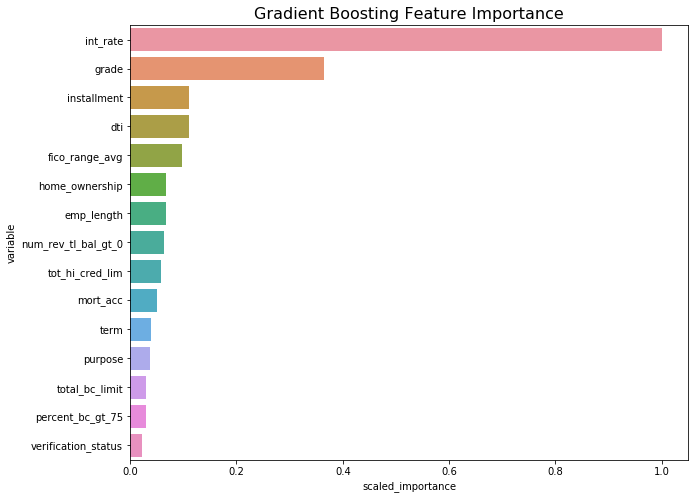

In [23]:
# get feature importance details
feat_importance= gbm_model.varimp(use_pandas=True)

# visualization
fig, ax = plt.subplots(figsize=(10, 8))
sns.barplot(x='scaled_importance', y='variable', data=feat_importance[:15], ax=ax)
ax.set_title('Gradient Boosting Feature Importance', fontsize=16)
plt.show()

In [14]:
my_metrics = gbm_model.model_performance(test_data=test)            

In [15]:
my_metrics


ModelMetricsBinomial: gbm
** Reported on test data. **

MSE: 0.15892494772950758
RMSE: 0.39865391974682446
LogLoss: 0.48595617118177065
Mean Per-Class Error: 0.33570173049747354
AUC: 0.7267296820601146
AUCPR: 0.4474078940767985
Gini: 0.45345936412022914

Confusion Matrix (Act/Pred) for max f1 @ threshold = 0.25312369624266906: 


,,0,1,Error,Rate
0,0,52163.0,24095.0,0.316,(24095.0/76258.0)
1,1,8394.0,15215.0,0.3555,(8394.0/23609.0)
2,Total,60557.0,39310.0,0.3253,(32489.0/99867.0)



Maximum Metrics: Maximum metrics at their respective thresholds


,metric,threshold,value,idx
0,max f1,0.253124,0.483638,220.0
1,max f2,0.131470,0.644983,314.0
2,max f0point5,0.355944,0.451789,150.0
3,max accuracy,0.477381,0.773779,84.0
4,max precision,0.747469,0.833333,4.0
5,max recall,0.017108,1.000000,399.0
6,max specificity,0.817170,0.999987,0.0
7,max absolute_mcc,0.268718,0.285953,210.0
8,max min_per_class_accuracy,0.244251,0.663314,227.0
9,max mean_per_class_accuracy,0.241404,0.664298,229.0



Gains/Lift Table: Avg response rate: 23.64 %, avg score: 23.26 %


,,group,cumulative_data_fraction,lower_threshold,lift,cumulative_lift,response_rate,score,cumulative_response_rate,cumulative_score,capture_rate,cumulative_capture_rate,gain,cumulative_gain
0,,1,0.010003,0.608942,2.955523,2.955523,0.698699,0.655662,0.698699,0.655662,0.029565,0.029565,195.552302,195.552302
1,,2,0.020007,0.568291,2.701467,2.828495,0.638639,0.587603,0.668669,0.621632,0.027024,0.056589,170.146660,182.849481
2,,3,0.030000,0.538574,2.454101,2.703780,0.580160,0.552659,0.639186,0.598657,0.024525,0.081113,145.410101,170.378019
3,,4,0.040003,0.517378,2.350022,2.615318,0.555556,0.527693,0.618273,0.580911,0.023508,0.104621,135.002188,161.531847
4,,5,0.050007,0.498951,2.197588,2.531756,0.519520,0.507606,0.598518,0.566247,0.021983,0.126604,119.758803,153.175566
5,,6,0.100003,0.434015,2.015474,2.273641,0.476467,0.463804,0.537499,0.515031,0.100767,0.227371,101.547441,127.364088
6,,7,0.149999,0.388753,1.764705,2.104007,0.417184,0.410190,0.497397,0.480086,0.088229,0.315600,76.470500,110.400691
7,,8,0.200006,0.353157,1.603417,1.978847,0.379055,0.370205,0.467808,0.452613,0.080181,0.395781,60.341701,97.884690
8,,9,0.299999,0.296218,1.355510,1.771082,0.320449,0.323279,0.418692,0.409505,0.135542,0.531323,35.551032,77.108191
9,,10,0.400002,0.249457,1.193153,1.626596,0.282067,0.272122,0.384535,0.375158,0.119319,0.650642,19.315320,62.659612


In [24]:
h2o.cluster().shutdown()

H2O session _sid_a11a closed.
